In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import pickle
from tqdm import tqdm


In [3]:
save_path = 'models/model_new.pt'
save_benchmark_path = 'models/model_new_benchmark.pt'
load_path = save_path
load_benchmark_path = save_benchmark_path

TRAIN=True
COMPUTE_INFO=True

In [4]:
transform = transforms.ToTensor()
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Print number of samples in the dataset
print(f"Number of samples in the dataset: {len(dataset)}")

Number of samples in the dataset: 60000


In [5]:
from fisherunlearn.clients_utils import split_dataset_by_class_distribution
# Compute the number of classes
num_classes = len(dataset.classes)

num_clients = 5
target_client = 0

# Create subsets
client_distributions =  np.zeros((num_clients, num_classes))
for i in range(num_clients):
    for j in range(5):
        client_distributions[i][j] = 1/6
    client_distributions[i][5+i] = 1/6

client_subsets = split_dataset_by_class_distribution(dataset, client_distributions)


classes_distributions = np.zeros((num_classes, num_classes))
for i in range(num_classes):
    classes_distributions[i][i] = 1
    
classes_subsets = split_dataset_by_class_distribution(dataset, classes_distributions)


# Create dataloaders
client_dataloaders = [ DataLoader(subset, batch_size=64, shuffle=True) for subset in client_subsets]

benchmark_dataloaders = [ DataLoader(subset, batch_size=64, shuffle=True) for subset in client_subsets]
benchmark_dataloaders.pop(target_client)
target_dataloader = DataLoader(client_subsets[target_client], batch_size=64, shuffle=True)

classes_dataloaders = [ DataLoader(subset, batch_size=64, shuffle=False) for subset in classes_subsets]
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Total number of samples: 7370


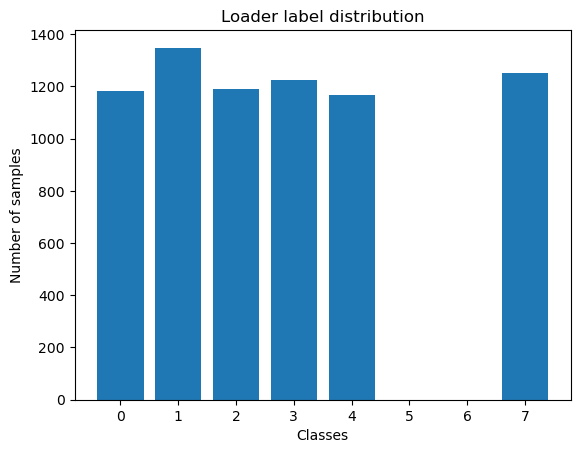

In [6]:
from collections import Counter

def get_label_distribution(dataloader):
    label_counts = Counter()
    for _, labels in dataloader:
        label_counts.update(labels.tolist())
    return dict(label_counts)

# Choose loader to visualize
loader = client_dataloaders[2]

label_distribution = get_label_distribution(loader)
print(f"Total number of samples: {len(loader.dataset)}")
#plot histogram
plt.bar(label_distribution.keys(), label_distribution.values())
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.title(f'Loader label distribution')
plt.show()


In [7]:
class FLNet(nn.Sequential):
    def __init__(self):
        super(FLNet, self).__init__(
            nn.Conv2d(1, 32, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

In [8]:
def compute_accuracy(model, dataloader, device=None):
    if device is None:
        device_ = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device_ = device
        
    model.to(device_)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device_), labels.to(device_)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    if device is None:
        model.cpu()

    return correct / total

def compute_dataloaders_accuracy(model, dataloaders):
    accuracies = []
    for idx, dataloader in enumerate(dataloaders):
        accuracy = compute_accuracy(model, dataloader)
        accuracies.append(accuracy)
    return accuracies

In [ ]:
def trainer(model, loss_fn, client_dataloaders, epochs):
    torch.cuda.empty_cache()
    # Training loop
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    #device = "cpu"
    model.to(device)

    for epoch in range(epochs):
        for client_loader in client_dataloaders:
            for imgs, labels in client_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                preds = model(imgs)
                loss = loss_fn(preds, labels)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
        # Evaluate on test set
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
        
    return model

# Save the model
def save_model_with_unique_name(model, base_path):
    # Split the base_path into the file name and extension
    base, ext = os.path.splitext(base_path)
    new_path = base_path
    counter = 1
    
    # Check if the file exists and update the filename if needed
    while os.path.exists(new_path):
        new_path = f"{base}({counter}){ext}"
        counter += 1

    torch.save(model.state_dict(), new_path)
    print(f"Model saved to {new_path}")

In [12]:
# Model
model = FLNet()
model_benchmark = FLNet()
loss_fn = nn.CrossEntropyLoss()

if TRAIN:
    model=trainer(model, loss_fn, client_dataloaders, epochs=10)
    save_model_with_unique_name(model, save_path)
    model_benchmark=trainer(model_benchmark, loss_fn, benchmark_dataloaders, epochs=10)
    save_model_with_unique_name(model_benchmark, save_benchmark_path)

else:
    model.load_state_dict(torch.load(load_path, weights_only=True))
    model_benchmark.load_state_dict(torch.load(load_benchmark_path, weights_only=True))

Epoch 1/10, Loss: 0.0067
Epoch 2/10, Loss: 0.0029
Epoch 3/10, Loss: 0.0001
Epoch 4/10, Loss: 0.0003
Epoch 5/10, Loss: 0.0000
Epoch 6/10, Loss: 0.0003
Epoch 7/10, Loss: 0.1573
Epoch 8/10, Loss: 0.0000
Epoch 9/10, Loss: 0.0054
Epoch 10/10, Loss: 0.0001
Model saved to models/model_new.pt
Epoch 1/10, Loss: 0.0808
Epoch 2/10, Loss: 0.0021
Epoch 3/10, Loss: 0.0042
Epoch 4/10, Loss: 0.0110
Epoch 5/10, Loss: 0.0014
Epoch 6/10, Loss: 0.0000
Epoch 7/10, Loss: 0.0043
Epoch 8/10, Loss: 0.0000
Epoch 9/10, Loss: 0.0000
Epoch 10/10, Loss: 0.0000
Model saved to models/model_new_benchmark.pt


In [13]:
if COMPUTE_INFO:
    from fisherunlearn import compute_informations, compute_client_information

    informations = compute_informations(model, loss_fn, client_dataloaders)
    
    with open('cached/informations.pkl', 'wb') as f:
            pickle.dump(informations, f)
else:
    with open('cached/informations.pkl', 'rb') as f:
        informations = pickle.load(f)

Computing clients information: 100%|██████████| 573/573 [00:15<00:00, 36.16batch/s]


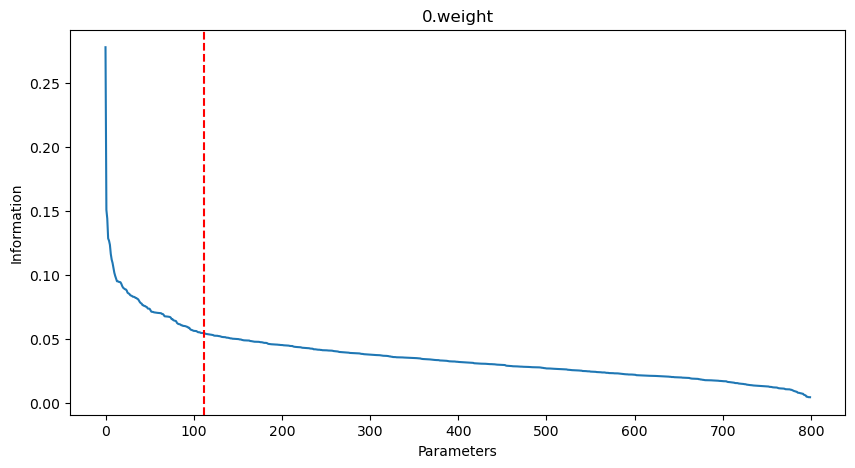

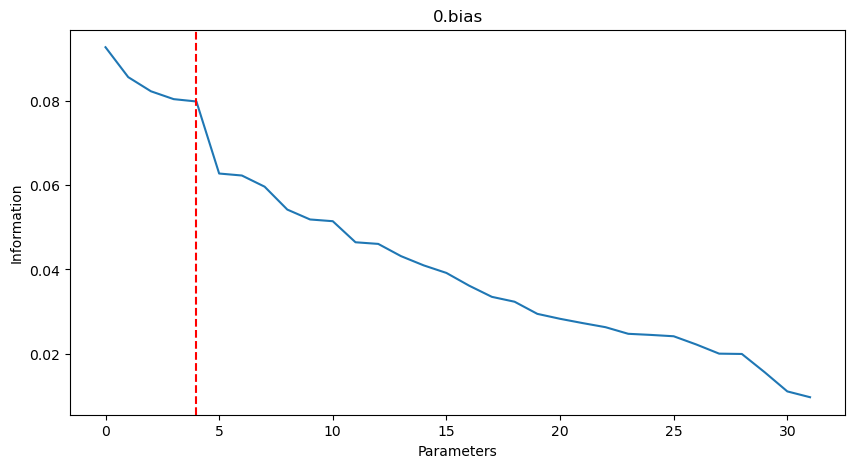

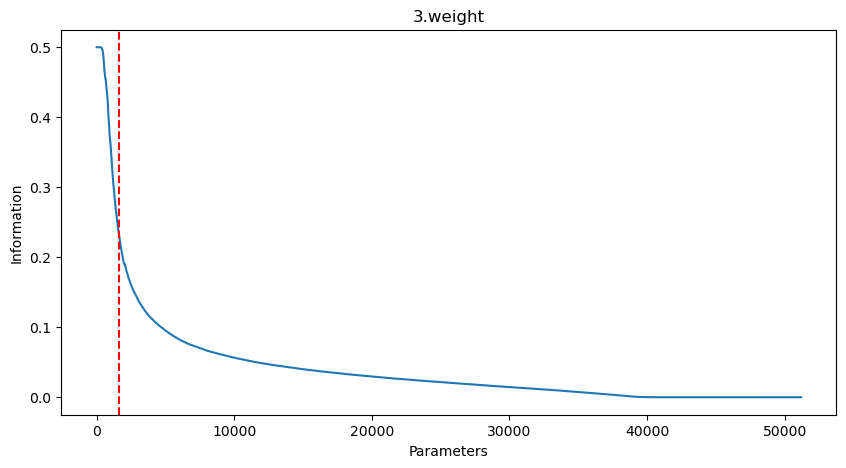

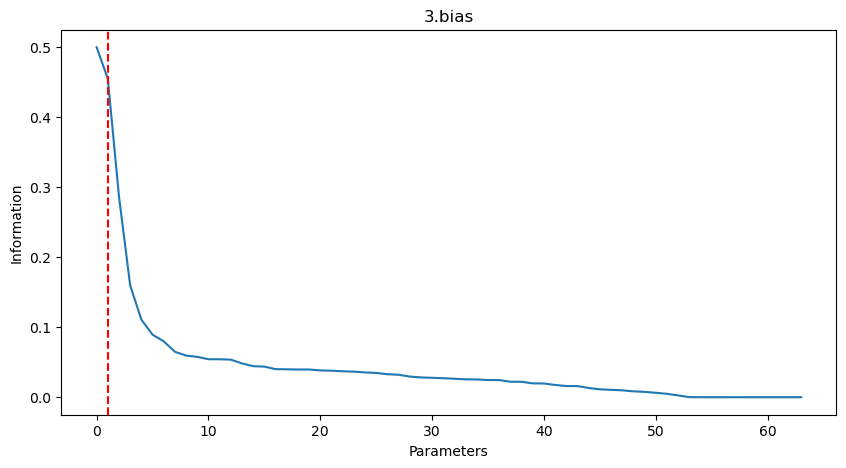

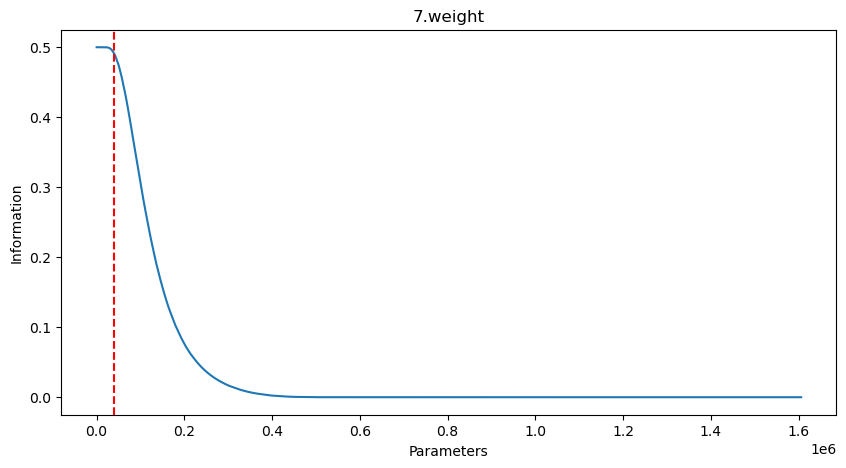

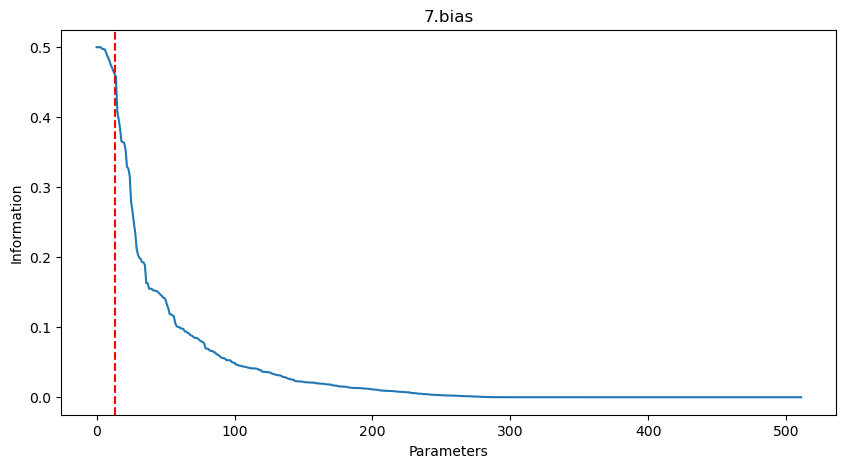

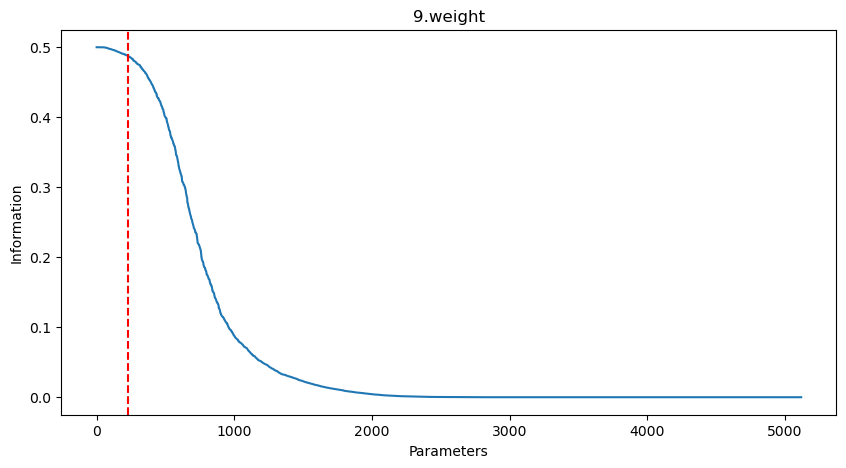

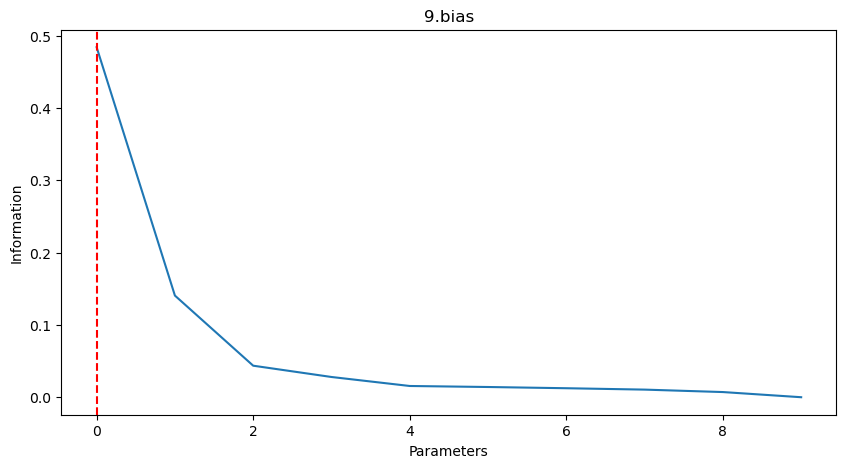

<All keys matched successfully>

In [14]:
from fisherunlearn import find_informative_params, reset_parameters

info=informations[target_client]
#informative_params = find_informative_params(info, method='parameters', percentage=10, graph=False)
informative_params = find_informative_params(info, method='information', percentage=30, graph=True)

resetted_model = FLNet()
resetted_model.load_state_dict(reset_parameters(model, informative_params), strict=False)


In [15]:
from fisherunlearn import UnlearnNet
for name in informative_params.keys():
    print(f"Layer: {name}, number of parameters: {len(informative_params[name])}")
retrainer = UnlearnNet(model, informative_params)
loss_fn = nn.CrossEntropyLoss()
retrainer = trainer(retrainer, loss_fn, benchmark_dataloaders, epochs=1)
retrained_model = FLNet()
retrained_model.load_state_dict(retrainer.get_retrained_params(), strict=False)

Layer: 0.weight, number of parameters: 113
Layer: 0.bias, number of parameters: 5
Layer: 3.weight, number of parameters: 1659
Layer: 3.bias, number of parameters: 2
Layer: 7.weight, number of parameters: 39843
Layer: 7.bias, number of parameters: 14
Layer: 9.weight, number of parameters: 230
Layer: 9.bias, number of parameters: 1
Epoch 1/1, Loss: 0.0000


<All keys matched successfully>

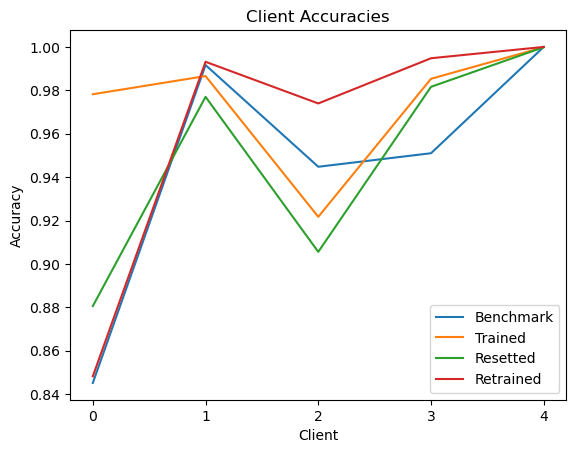

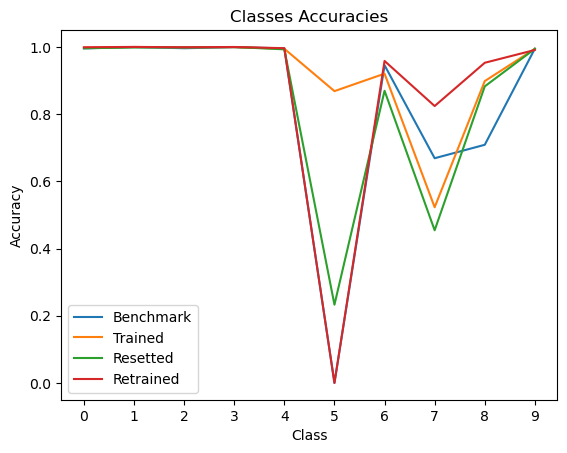

In [16]:

plt.plot(compute_dataloaders_accuracy(model_benchmark, client_dataloaders), label='Benchmark')
plt.plot(compute_dataloaders_accuracy(model, client_dataloaders), label='Trained')
plt.plot(compute_dataloaders_accuracy(resetted_model, client_dataloaders), label='Resetted')
plt.plot(compute_dataloaders_accuracy(retrained_model, client_dataloaders), label='Retrained')
plt.legend()
plt.xlabel('Client')
plt.xticks(np.arange(0, 5, 1))
plt.ylabel('Accuracy')
plt.title('Client Accuracies')
plt.show()

plt.plot(compute_dataloaders_accuracy(model_benchmark, classes_dataloaders), label='Benchmark')
plt.plot(compute_dataloaders_accuracy(model, classes_dataloaders), label='Trained')
plt.plot(compute_dataloaders_accuracy(resetted_model, classes_dataloaders), label='Resetted')
plt.plot(compute_dataloaders_accuracy(retrained_model, classes_dataloaders), label='Retrained')
plt.legend()
plt.xlabel('Class')
plt.xticks(np.arange(0, 10, 1))
plt.ylabel('Accuracy')
plt.title('Classes Accuracies')
plt.show()


In [17]:
print("Benchmark model test accuracy:")
print(compute_accuracy(model_benchmark, test_dataloader))
print("Trained model test accuracy:")
print(compute_accuracy(model, test_dataloader))
print("Resetted model test accuracy:")
print(compute_accuracy(resetted_model, test_dataloader))
print("Retrained model test accuracy:")
print(compute_accuracy(retrained_model, test_dataloader))


print("Benchmark model target client accuracy:")
print(compute_accuracy(model_benchmark, target_dataloader))
print("Trained model target client accuracy:")
print(compute_accuracy(model, target_dataloader))
print("Resetted model target client accuracy:")
print(compute_accuracy(resetted_model, target_dataloader))
print("Retrained model target client accuracy:")
print(compute_accuracy(retrained_model, target_dataloader))

Benchmark model test accuracy:
0.842
Trained model test accuracy:
0.9136
Resetted model test accuracy:
0.846
Retrained model test accuracy:
0.8796
Benchmark model target client accuracy:
0.8451603943896681
Trained model target client accuracy:
0.9781974725732537
Resetted model target client accuracy:
0.8805721427579503
Retrained model target client accuracy:
0.8482155256214414


Calculating benchmark accuracies (retrained_model)...
  Benchmark Global Test Accuracy: 0.8420
  Benchmark Target Client Accuracy: 0.8452


Processing Percentages:   0%|          | 0/11 [00:00<?, ?it/s]


Evaluating unlearning for different parameter percentages...

--- Processing Percentage: 0% ---
  Found 8 informative parameter names.
  Reset-Only Global Test Accuracy: 0.9162
  Reset-Only Target Client Accuracy: 0.9792
  Delta Test Acc (Reset): -0.0742
  Delta Target Acc (Reset): -0.1340
  Retraining from reset for 1 epoch(s)...
Epoch 1/1, Loss: 0.0000


Processing Percentages:   9%|▉         | 1/11 [00:09<01:38,  9.86s/it]

  Retrained-from-Reset Global Test Accuracy: 0.8730
  Retrained-from-Reset Target Client Accuracy: 0.8559
  Delta Test Acc (Retrained): -0.0310
  Delta Target Acc (Retrained): -0.0107

--- Processing Percentage: 10% ---
  Found 8 informative parameter names.
  Reset-Only Global Test Accuracy: 0.9051
  Reset-Only Target Client Accuracy: 0.9726
  Delta Test Acc (Reset): -0.0631
  Delta Target Acc (Reset): -0.1275
  Retraining from reset for 1 epoch(s)...
Epoch 1/1, Loss: 0.0000


Processing Percentages:  18%|█▊        | 2/11 [00:19<01:27,  9.67s/it]

  Retrained-from-Reset Global Test Accuracy: 0.8722
  Retrained-from-Reset Target Client Accuracy: 0.8649
  Delta Test Acc (Retrained): -0.0302
  Delta Target Acc (Retrained): -0.0197

--- Processing Percentage: 20% ---
  Found 8 informative parameter names.
  Reset-Only Global Test Accuracy: 0.8767
  Reset-Only Target Client Accuracy: 0.9332
  Delta Test Acc (Reset): -0.0347
  Delta Target Acc (Reset): -0.0880
  Retraining from reset for 1 epoch(s)...
Epoch 1/1, Loss: 0.0101


Processing Percentages:  27%|██▋       | 3/11 [00:28<01:16,  9.58s/it]

  Retrained-from-Reset Global Test Accuracy: 0.8548
  Retrained-from-Reset Target Client Accuracy: 0.8486
  Delta Test Acc (Retrained): -0.0128
  Delta Target Acc (Retrained): -0.0035

--- Processing Percentage: 30% ---
  Found 8 informative parameter names.
  Reset-Only Global Test Accuracy: 0.8460
  Reset-Only Target Client Accuracy: 0.8806
  Delta Test Acc (Reset): -0.0040
  Delta Target Acc (Reset): -0.0354
  Retraining from reset for 1 epoch(s)...
Epoch 1/1, Loss: 0.0000


Processing Percentages:  36%|███▋      | 4/11 [00:39<01:10, 10.14s/it]

  Retrained-from-Reset Global Test Accuracy: 0.8477
  Retrained-from-Reset Target Client Accuracy: 0.8454
  Delta Test Acc (Retrained): -0.0057
  Delta Target Acc (Retrained): -0.0003

--- Processing Percentage: 40% ---
  Found 8 informative parameter names.
  Reset-Only Global Test Accuracy: 0.8228
  Reset-Only Target Client Accuracy: 0.8535
  Delta Test Acc (Reset): 0.0192
  Delta Target Acc (Reset): -0.0083
  Retraining from reset for 1 epoch(s)...
Epoch 1/1, Loss: 0.0000


Processing Percentages:  45%|████▌     | 5/11 [00:50<01:02, 10.45s/it]

  Retrained-from-Reset Global Test Accuracy: 0.8562
  Retrained-from-Reset Target Client Accuracy: 0.8472
  Delta Test Acc (Retrained): -0.0142
  Delta Target Acc (Retrained): -0.0021

--- Processing Percentage: 50% ---
  Found 8 informative parameter names.
  Reset-Only Global Test Accuracy: 0.8125
  Reset-Only Target Client Accuracy: 0.8486
  Delta Test Acc (Reset): 0.0295
  Delta Target Acc (Reset): -0.0035
  Retraining from reset for 1 epoch(s)...
Epoch 1/1, Loss: 0.0000


Processing Percentages:  55%|█████▍    | 6/11 [01:01<00:53, 10.67s/it]

  Retrained-from-Reset Global Test Accuracy: 0.8161
  Retrained-from-Reset Target Client Accuracy: 0.8434
  Delta Test Acc (Retrained): 0.0259
  Delta Target Acc (Retrained): 0.0018

--- Processing Percentage: 60% ---
  Found 8 informative parameter names.
  Reset-Only Global Test Accuracy: 0.7621
  Reset-Only Target Client Accuracy: 0.8436
  Delta Test Acc (Reset): 0.0799
  Delta Target Acc (Reset): 0.0015
  Retraining from reset for 1 epoch(s)...
Epoch 1/1, Loss: 0.0001


Processing Percentages:  64%|██████▎   | 7/11 [01:13<00:43, 10.82s/it]

  Retrained-from-Reset Global Test Accuracy: 0.8492
  Retrained-from-Reset Target Client Accuracy: 0.8460
  Delta Test Acc (Retrained): -0.0072
  Delta Target Acc (Retrained): -0.0008

--- Processing Percentage: 70% ---
  Found 8 informative parameter names.
  Reset-Only Global Test Accuracy: 0.7458
  Reset-Only Target Client Accuracy: 0.8371
  Delta Test Acc (Reset): 0.0962
  Delta Target Acc (Reset): 0.0081
  Retraining from reset for 1 epoch(s)...
Epoch 1/1, Loss: 0.0010


Processing Percentages:  73%|███████▎  | 8/11 [01:25<00:33, 11.22s/it]

  Retrained-from-Reset Global Test Accuracy: 0.8182
  Retrained-from-Reset Target Client Accuracy: 0.8453
  Delta Test Acc (Retrained): 0.0238
  Delta Target Acc (Retrained): -0.0001

--- Processing Percentage: 80% ---
  Found 8 informative parameter names.
  Reset-Only Global Test Accuracy: 0.6690
  Reset-Only Target Client Accuracy: 0.7786
  Delta Test Acc (Reset): 0.1730
  Delta Target Acc (Reset): 0.0665
  Retraining from reset for 1 epoch(s)...
Epoch 1/1, Loss: 0.1622


Processing Percentages:  82%|████████▏ | 9/11 [01:42<00:26, 13.12s/it]

  Retrained-from-Reset Global Test Accuracy: 0.8534
  Retrained-from-Reset Target Client Accuracy: 0.8481
  Delta Test Acc (Retrained): -0.0114
  Delta Target Acc (Retrained): -0.0029

--- Processing Percentage: 90% ---
  Found 8 informative parameter names.
  Reset-Only Global Test Accuracy: 0.3672
  Reset-Only Target Client Accuracy: 0.4240
  Delta Test Acc (Reset): 0.4748
  Delta Target Acc (Reset): 0.4212
  Retraining from reset for 1 epoch(s)...
Epoch 1/1, Loss: 0.0015


Processing Percentages:  91%|█████████ | 10/11 [02:00<00:14, 14.67s/it]

  Retrained-from-Reset Global Test Accuracy: 0.8247
  Retrained-from-Reset Target Client Accuracy: 0.8442
  Delta Test Acc (Retrained): 0.0173
  Delta Target Acc (Retrained): 0.0010

--- Processing Percentage: 100% ---
  Found 8 informative parameter names.
  Reset-Only Global Test Accuracy: 0.1028
  Reset-Only Target Client Accuracy: 0.0000
  Delta Test Acc (Reset): 0.7392
  Delta Target Acc (Reset): 0.8452
  Retraining from reset for 1 epoch(s)...
Epoch 1/1, Loss: 1.9253


Processing Percentages: 100%|██████████| 11/11 [02:14<00:00, 12.19s/it]

  Retrained-from-Reset Global Test Accuracy: 0.1135
  Retrained-from-Reset Target Client Accuracy: 0.1872
  Delta Test Acc (Retrained): 0.7285
  Delta Target Acc (Retrained): 0.6580

Plotting results...


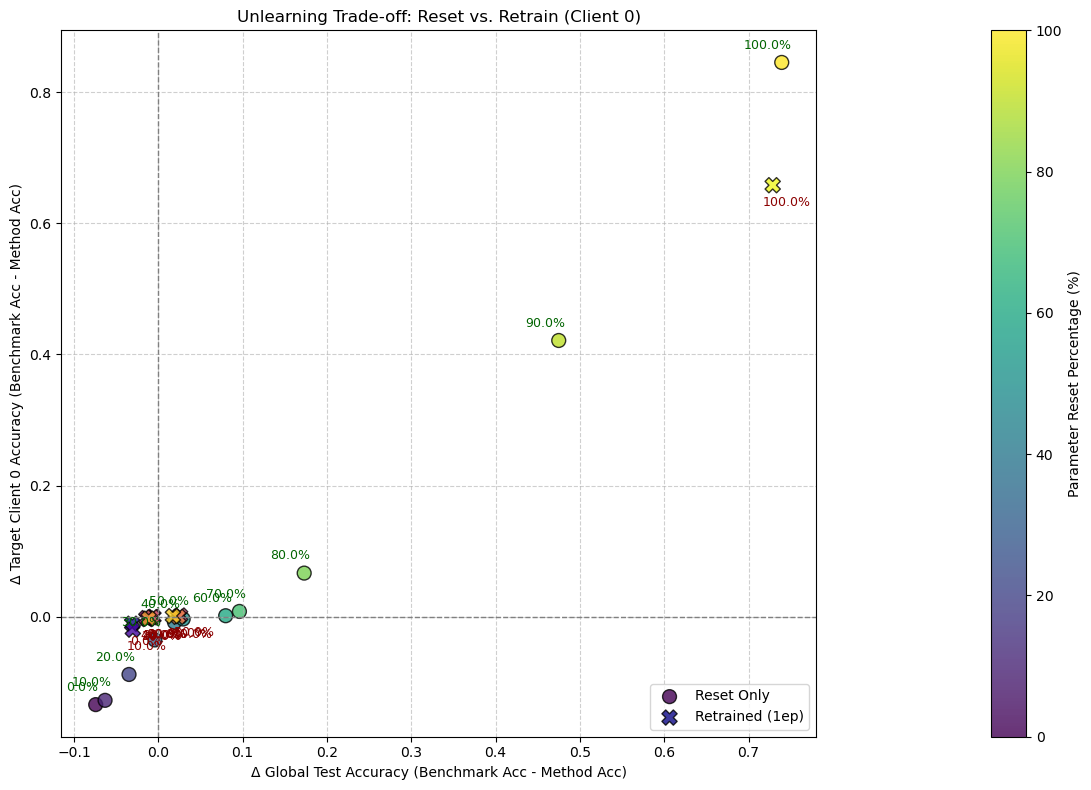


Computed Deltas:
{'delta_test_accuracies_reset': [-0.07420000000000004, -0.06310000000000004, -0.034700000000000064, -0.0040000000000000036, 0.019199999999999995, 0.02949999999999997, 0.07989999999999997, 0.09619999999999995, 0.17299999999999993, 0.47479999999999994, 0.7392], 'delta_target_accuracies_reset': [-0.13400916539369534, -0.1274822941258159, -0.08804332731565068, -0.0354117483682822, -0.008332176086654708, -0.0034717400361061745, 0.001527565615886628, 0.008054436883766058, 0.06651853909179273, 0.42119150118039156, 0.8451603943896681], 'delta_test_accuracies_retrained': [-0.031000000000000028, -0.030200000000000005, -0.012800000000000034, -0.005700000000000038, -0.01419999999999999, 0.025899999999999923, -0.007199999999999984, 0.023799999999999932, -0.011400000000000077, 0.017299999999999982, 0.7284999999999999], 'delta_target_accuracies_retrained': [-0.01069295931120684, -0.01971948340508267, -0.0034717400361061745, -0.00027773920288853837, -0.0020830440216637047, 0.00180530

In [29]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
from typing import Callable, Dict, List, Optional, Any, Union

# Assume these functions are defined elsewhere in your library:
# - compute_accuracy(model, dataloader, device) -> float
# - find_informative_params(info, method, param_percentage, graph) -> List[str]
# - reset_parameters(original_model, params_to_reset) -> Dict[str, torch.Tensor]
# - trainer(model, loss_fn, client_dataloaders, epochs, ...) -> trained_model # Your trainer function

class UnlearningTradeoffPlotter:
    """
    Computes and plots the unlearning trade-off graph.

    Compares the drop in accuracy on a global test set vs. the drop in accuracy
    on the target client's data for various parameter reset percentages. Plots results
    for both the reset-only model and a model retrained after resetting. Deltas
    are calculated relative to a benchmark 'retrained_model'.
    """
    def __init__(
        self,
        # Models & Data
        original_model: torch.nn.Module,
        retrained_model: torch.nn.Module, # Benchmark model (e.g., model_benchmark)
        informations: Dict[Any, Dict[str, torch.Tensor]],
        target_client: Any,
        target_client_dataloader: torch.utils.data.DataLoader,
        global_test_dataloader: torch.utils.data.DataLoader,
        benchmark_dataloaders: List[torch.utils.data.DataLoader], # DataLoaders excluding target_client

        # Core Functions & Model Arch
        model_architecture_fn: Callable[..., torch.nn.Module],
        model_init_args: Dict[str, Any],
        find_informative_params_fn: Callable[..., List[str]],
        reset_parameters_fn: Callable[..., Dict[str, torch.Tensor]],
        compute_accuracy_fn: Callable[..., float],
        trainer_fn: Callable[..., torch.nn.Module], # Your trainer function
        loss_fn_retrain: nn.Module, # Loss function for retraining step

        # Configuration
        epochs_retrain: int = 1, # Epochs for retraining after reset
        device: Optional[Union[str, torch.device]] = None,
        verbose: bool = True
    ):
        """
        Initializes the plotter with models, data, and functions.
        """
        self.original_model = original_model.cpu() # Keep original on CPU
        self.retrained_model = retrained_model
        self.informations = informations
        self.target_client = target_client
        self.target_client_dataloader = target_client_dataloader
        self.global_test_dataloader = global_test_dataloader
        self.benchmark_dataloaders = benchmark_dataloaders # Data for retraining

        self.model_architecture_fn = model_architecture_fn
        self.model_init_args = model_init_args
        self.find_informative_params_fn = find_informative_params_fn
        self.reset_parameters_fn = reset_parameters_fn
        self.compute_accuracy_fn = compute_accuracy_fn
        self.trainer_fn = trainer_fn # Store trainer function
        self.loss_fn_retrain = loss_fn_retrain # Store loss for retraining
        self.epochs_retrain = epochs_retrain # Store epochs for retraining

        self.verbose = verbose

        if device is None:
            self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self._device = torch.device(device)

        # Results storage
        self.delta_test_accuracies_reset: List[float] = []
        self.delta_target_accuracies_reset: List[float] = []
        self.delta_test_accuracies_retrained: List[float] = []
        self.delta_target_accuracies_retrained: List[float] = []
        self.param_percentages_tested: Optional[np.ndarray] = None

        # Calculate benchmark accuracies once
        self._calculate_benchmark_accuracies()

    def _calculate_benchmark_accuracies(self):
        """Computes and stores benchmark accuracies."""
        if self.verbose: print("Calculating benchmark accuracies (retrained_model)...")
        self.retrained_model.to(self._device)
        self.retrained_test_acc = self.compute_accuracy_fn(
            self.retrained_model, self.global_test_dataloader, device=self._device
        )
        self.retrained_target_acc = self.compute_accuracy_fn(
            self.retrained_model, self.target_client_dataloader, device=self._device
        )
        # Optional: Move back to CPU
        # self.retrained_model.cpu()
        if self.verbose:
            print(f"  Benchmark Global Test Accuracy: {self.retrained_test_acc:.4f}")
            print(f"  Benchmark Target Client Accuracy: {self.retrained_target_acc:.4f}")

    def compute_deltas(
        self,
        param_percentages: Optional[Union[List[float], np.ndarray]] = None
    ) -> Dict[str, List[float]]:
        """
        Computes the accuracy deltas for the specified percentages for both
        reset-only and retrained-from-reset models.

        Args:
            param_percentages: List/array of percentages (0-100). Defaults to [0, 10,..., 100].

        Returns:
            Dictionary containing the computed deltas and percentages.
        """
        if param_percentages is None:
            self.param_percentages_tested = np.linspace(0, 100, 11).astype(int)
        else:
            self.param_percentages_tested = np.array(param_percentages)

        # Reset results lists
        self.delta_test_accuracies_reset = []
        self.delta_target_accuracies_reset = []
        self.delta_test_accuracies_retrained = []
        self.delta_target_accuracies_retrained = []

        try:
            info = self.informations[self.target_client]
        except KeyError:
            raise ValueError(f"Target client '{self.target_client}' not found in informations dict.")

        iterator = tqdm(self.param_percentages_tested, desc="Processing Percentages") if self.verbose else self.param_percentages_tested
        if self.verbose: print("\nEvaluating unlearning for different parameter percentages...")

        for perc in iterator:
            if self.verbose: print(f"\n--- Processing Percentage: {perc}% ---")

            resetted_model = None  # Initialize to None at the start of the loop
            retrained_from_reset_model = None # Initialize to None

            try:
                # --- Reset Step ---
                informative_params = self.find_informative_params_fn(
                    info, method='information', percentage=perc, graph=False
                )
                if self.verbose: print(f"  Found {len(informative_params)} informative parameter names.")

                resetted_model = self.model_architecture_fn(**self.model_init_args)
                resetted_state_dict = self.reset_parameters_fn(self.original_model, informative_params)
                resetted_model.load_state_dict(resetted_state_dict, strict=True)
                resetted_model.to(self._device)

                # Evaluate Reset-Only Model
                reset_test_acc = self.compute_accuracy_fn(resetted_model, self.global_test_dataloader, device=self._device)
                reset_target_acc = self.compute_accuracy_fn(resetted_model, self.target_client_dataloader, device=self._device)
                if self.verbose:
                    print(f"  Reset-Only Global Test Accuracy: {reset_test_acc:.4f}")
                    print(f"  Reset-Only Target Client Accuracy: {reset_target_acc:.4f}")

                # Calculate Deltas for Reset-Only
                delta_test_reset = self.retrained_test_acc - reset_test_acc
                delta_target_reset = self.retrained_target_acc - reset_target_acc
                self.delta_test_accuracies_reset.append(delta_test_reset)
                self.delta_target_accuracies_reset.append(delta_target_reset)
                if self.verbose:
                    print(f"  Delta Test Acc (Reset): {delta_test_reset:.4f}")
                    print(f"  Delta Target Acc (Reset): {delta_target_reset:.4f}")

                # --- Retrain Step ---
                if self.verbose: print(f"  Retraining from reset for {self.epochs_retrain} epoch(s)...")

                # Make a copy IF your trainer modifies the model *and* you still need the reset-only state later
                # If your trainer returns a new model or modifies in-place and you don't need the reset-only state after this,
                # you might not need a deepcopy. However, deepcopy is safer if unsure.
                # model_to_retrain = copy.deepcopy(resetted_model) # Safer if trainer modifies in-place extensively

                # Assuming your trainer modifies the model passed to it in-place (common practice)
                # or returns the *same* modified instance.
                retrained_from_reset_model = self.trainer_fn(
                    model=resetted_model, # Pass the model instance to train
                    loss_fn=self.loss_fn_retrain,
                    client_dataloaders=self.benchmark_dataloaders,
                    epochs=self.epochs_retrain
                    # Add other trainer args if needed
                )
                # Ensure the model is on the correct device after training
                retrained_from_reset_model.to(self._device)


                # Evaluate Retrained-from-Reset Model
                retrained_r_test_acc = self.compute_accuracy_fn(retrained_from_reset_model, self.global_test_dataloader, device=self._device)
                retrained_r_target_acc = self.compute_accuracy_fn(retrained_from_reset_model, self.target_client_dataloader, device=self._device)
                if self.verbose:
                    print(f"  Retrained-from-Reset Global Test Accuracy: {retrained_r_test_acc:.4f}")
                    print(f"  Retrained-from-Reset Target Client Accuracy: {retrained_r_target_acc:.4f}")

                # Calculate Deltas for Retrained-from-Reset
                delta_test_retrained = self.retrained_test_acc - retrained_r_test_acc
                delta_target_retrained = self.retrained_target_acc - retrained_r_target_acc
                self.delta_test_accuracies_retrained.append(delta_test_retrained)
                self.delta_target_accuracies_retrained.append(delta_target_retrained)
                if self.verbose:
                    print(f"  Delta Test Acc (Retrained): {delta_test_retrained:.4f}")
                    print(f"  Delta Target Acc (Retrained): {delta_target_retrained:.4f}")

            except Exception as e:
                print(f"\nERROR processing percentage {perc}: {e}")
                # Append NaN or handle appropriately if one percentage fails
                self.delta_test_accuracies_reset.append(float('nan'))
                self.delta_target_accuracies_reset.append(float('nan'))
                self.delta_test_accuracies_retrained.append(float('nan'))
                self.delta_target_accuracies_retrained.append(float('nan'))
                # Optionally re-raise the exception if you want processing to stop
                # raise e

            finally:
                # --- Clean up memory ---
                # Store references before potential deletion
                final_resetted_ref = resetted_model
                final_retrained_ref = retrained_from_reset_model

                # Attempt to delete the retrained_from_reset_model ONLY IF
                # it was successfully created AND it's a different object
                # from the initial resetted_model.
                if final_retrained_ref is not None and final_resetted_ref is not None and final_retrained_ref is not final_resetted_ref:
                    # print("Deleting separate retrained_from_reset_model") # Debug print
                    del retrained_from_reset_model
                    final_retrained_ref = None # Clear reference after delete

                # Attempt to delete the resetted_model IF it was successfully created.
                # This will also delete the retrained model if it was modified in-place.
                if final_resetted_ref is not None:
                    # print("Deleting resetted_model (or in-place retrained)") # Debug print
                    del resetted_model
                    final_resetted_ref = None # Clear reference after delete


                # Clear GPU cache periodically if memory is an issue
                if self._device.type == 'cuda':
                   torch.cuda.empty_cache()


        results = {
            'delta_test_accuracies_reset': self.delta_test_accuracies_reset,
            'delta_target_accuracies_reset': self.delta_target_accuracies_reset,
            'delta_test_accuracies_retrained': self.delta_test_accuracies_retrained,
            'delta_target_accuracies_retrained': self.delta_target_accuracies_retrained,
            'param_percentages': list(self.param_percentages_tested)
        }
        return results

    def plot(
        self,
        plot_kwargs_reset: Optional[Dict[str, Any]] = None,
        plot_kwargs_retrained: Optional[Dict[str, Any]] = None,
        show_plot: bool = True,
        title_suffix: str = ""
    ):
        """
        Generates the trade-off plot showing both reset-only and retrained results.

        Args:
            plot_kwargs_reset: Dict of keyword arguments for reset-only plt.scatter.
            plot_kwargs_retrained: Dict of keyword arguments for retrained plt.scatter.
            show_plot: If True, displays the plot using plt.show().
            title_suffix: Optional string to append to the plot title.
        """
        if not self.delta_test_accuracies_reset or self.param_percentages_tested is None:
            raise RuntimeError("Deltas have not been computed. Call compute_deltas() first.")

        if plot_kwargs_reset is None: plot_kwargs_reset = {}
        if plot_kwargs_retrained is None: plot_kwargs_retrained = {}

        if self.verbose: print("\nPlotting results...")
        plt.figure(figsize=(11, 8)) # Slightly larger figure for legend

        # --- Plot Reset-Only Results ---
        scatter_defaults_reset = {
            'c': self.param_percentages_tested, 'cmap': 'viridis', 's': 100,
            'alpha': 0.8, 'edgecolors': 'k', 'marker': 'o', 'label': 'Reset Only'
        }
        scatter_defaults_reset.update(plot_kwargs_reset) # Apply user overrides
        scatter1 = plt.scatter(
            self.delta_test_accuracies_reset,
            self.delta_target_accuracies_reset,
            **scatter_defaults_reset
        )

        # --- Plot Retrained-from-Reset Results ---
        scatter_defaults_retrained = {
             'c': self.param_percentages_tested, 'cmap': 'plasma', 's': 120, # Different map/size/marker
             'alpha': 0.8, 'edgecolors': 'k', 'marker': 'X', 'label': f'Retrained ({self.epochs_retrain}ep)'
        }
        scatter_defaults_retrained.update(plot_kwargs_retrained) # Apply user overrides
        scatter2 = plt.scatter(
            self.delta_test_accuracies_retrained,
            self.delta_target_accuracies_retrained,
            **scatter_defaults_retrained
        )

        # Add annotations (labeling percentage for both points)
        for i, perc in enumerate(self.param_percentages_tested):
             perc_label = f"{int(perc) if perc == int(perc) else perc:.1f}%"
             # Annotate reset point
             plt.annotate(perc_label,
                          (self.delta_test_accuracies_reset[i], self.delta_target_accuracies_reset[i]),
                          textcoords="offset points", xytext=(-10, 10), # Offset slightly
                          ha='center', fontsize=9, color='darkgreen') # Color code maybe
             # Annotate retrained point
             plt.annotate(perc_label,
                          (self.delta_test_accuracies_retrained[i], self.delta_target_accuracies_retrained[i]),
                          textcoords="offset points", xytext=(10, -15), # Offset differently
                          ha='center', fontsize=9, color='darkred')

        # Add a colorbar (can choose one, or maybe better to use legend only)
        plt.colorbar(scatter1, label='Parameter Reset Percentage (%)', location='right', anchor=(1.2, 0.5)) # Adjust colorbar position if needed

        plt.xlabel('Δ Global Test Accuracy (Benchmark Acc - Method Acc)')
        plt.ylabel(f'Δ Target Client {self.target_client} Accuracy (Benchmark Acc - Method Acc)')
        plt.title(f'Unlearning Trade-off: Reset vs. Retrain (Client {self.target_client}){title_suffix}')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.axhline(0, color='grey', lw=1.0, linestyle='--')
        plt.axvline(0, color='grey', lw=1.0, linestyle='--')
        plt.legend(loc='best') # Add legend to distinguish markers
        plt.tight_layout()

        if show_plot:
            plt.show()

    def run(
        self,
        param_percentages: Optional[Union[List[float], np.ndarray]] = None,
        plot_kwargs_reset: Optional[Dict[str, Any]] = None,
        plot_kwargs_retrained: Optional[Dict[str, Any]] = None,
        show_plot: bool = True,
        title_suffix: str = ""
    ) -> Dict[str, List[float]]:
        """
        Runs both delta computation and plotting for reset and retrained models.

        Args:
            (See compute_deltas and plot methods for argument details)

        Returns:
            Dictionary containing the computed deltas and percentages.
        """
        results = self.compute_deltas(param_percentages)
        self.plot(
            plot_kwargs_reset=plot_kwargs_reset,
            plot_kwargs_retrained=plot_kwargs_retrained,
            show_plot=show_plot,
            title_suffix=title_suffix
        )
        return results


# --- Example Usage (using placeholders from your notebook) ---
# Ensure the necessary functions and data are defined/imported
# from fisherunlearn import find_informative_params, reset_parameters
# from your_notebook_module import compute_accuracy, FLNet, trainer # Assuming these are defined

loss_retrain = nn.CrossEntropyLoss() # Define the loss for the retraining step

plotter = UnlearningTradeoffPlotter(
    # Models & Data
    original_model=model,
    retrained_model=model_benchmark, # Benchmark model
    informations=informations,
    target_client=target_client,
    target_client_dataloader=target_dataloader,
    global_test_dataloader=test_dataloader,
    benchmark_dataloaders=benchmark_dataloaders, # DataLoaders excluding target_client

#     # Core Functions & Model Arch
    model_architecture_fn=FLNet,
    model_init_args={},
    find_informative_params_fn=find_informative_params,
    reset_parameters_fn=reset_parameters,
    compute_accuracy_fn=compute_accuracy,
    trainer_fn=trainer, # Your trainer function
    loss_fn_retrain=loss_retrain, # Loss for retraining step

#     # Configuration
    epochs_retrain=1, # Epochs for retraining after reset
    device=None,
    verbose=True
)

# # Run computation and plotting
results = plotter.run(param_percentages=np.linspace(0, 100, 11).astype(int)) 

print("\nComputed Deltas:")
print(results)